In [3]:
# %%
# Standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from pandas import read_csv
import time
sns.set(style='whitegrid', palette='muted')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8

# Sklearn
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

from sklearn.cluster import KMeans
from scipy.stats import uniform

from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import xgboost as xgb

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score

from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [4]:
import project_helper
import importlib
importlib.reload(project_helper)


<module 'project_helper' from 'c:\\Users\\sing\\Documents\\ECON4305 github\\Predicting-US-Bankruptcy\\project_helper.py'>

Best model is defined as the model that is low in complexity (high in regularization) and yet yields a good result according to the objective function

How to interpret scoring: first value is the average of objective function across all folds in walk forward validation, estimating the test set objective function value, second is the standard error of the statistic across folds

# Data loading and preprocessing

In [5]:
# %%
# Load and process data
bankruptcy_df = pd.read_excel('US Bankruptcy Dataset.xlsx', sheet_name=2)
print(bankruptcy_df.head())

  company_name status_label  year       X1       X2      X3      X4       X5  \
0          C_1        alive  1999  511.267  833.107  18.373  89.031  336.018   
1          C_1        alive  2000  485.856  713.811  18.577  64.367  320.590   
2          C_1        alive  2001  436.656  526.477  22.496  27.207  286.588   
3          C_1        alive  2002  396.412  496.747  27.172  30.745  259.954   
4          C_1        alive  2003  432.204  523.302  26.680  47.491  247.245   

       X6       X7  ...        X9      X10      X11     X12      X13      X14  \
0  35.163  128.348  ...  1024.333  740.998  180.447  70.658  191.226  163.816   
1  18.531  115.187  ...   874.255  701.854  179.987  45.790  160.444  125.392   
2 -58.939   77.528  ...   638.721  710.199  217.699   4.711  112.244  150.464   
3 -12.410   66.322  ...   606.337  686.621  164.658   3.573  109.590  203.575   
4   3.504  104.661  ...   651.958  709.292  248.666  20.811  128.656  131.261   

       X15       X16      X17   

In [6]:


# %% [markdown]
# Transform existing data into various financial ratios
# 
# X19	Debt-to-Equity Ratio: X17/X15 <br>
# X20	Long-Term Debt-to-Capitilization Ratio: X11/(X11+X15) <br>
# X21	Current Ratio: X1/X14 <br>
# X22	Return on Assets (ROA): (X6/X10) * 100 <br>
# X23	Return on Equity (ROE): (X6/X15) * 100 <br>
# X24	Altman Z-score: 1.2*(X1- X14)/X10 + 1.4*X15/X10 + 3.3*X12/X10 + 0.6*X8/X17 + 0.999*X9/X10

# %%
# Feature Engineering
bankruptcy_df['X19'] = bankruptcy_df['X17'] / bankruptcy_df['X15'] # 
bankruptcy_df['X20'] = bankruptcy_df['X11'] / (bankruptcy_df['X11'] + bankruptcy_df['X15'])
bankruptcy_df['X21'] = bankruptcy_df['X1'] / bankruptcy_df['X14']
bankruptcy_df['X22'] = (bankruptcy_df['X6'] / bankruptcy_df['X10']) * 100
bankruptcy_df['X23'] = (bankruptcy_df['X6'] / bankruptcy_df['X15']) * 100
bankruptcy_df['X24'] = (
    1.2 * (bankruptcy_df['X1'] - bankruptcy_df['X14']) / bankruptcy_df['X10'] +
    1.4 * bankruptcy_df['X15'] / bankruptcy_df['X10'] +
    3.3 * bankruptcy_df['X12'] / bankruptcy_df['X10'] +
    0.6 * bankruptcy_df['X8'] / bankruptcy_df['X17'] +
    0.999 * bankruptcy_df['X9'] / bankruptcy_df['X10']
)

print(bankruptcy_df.head())

# %% [markdown]
# Add GDP growth as a macro indicator
# 
# X15 US GDP Growth YoY

# %%
# Load GDP growth data
gdp_data = pd.read_csv('GDPC1.csv')
gdp_data['DATE'] = pd.to_datetime(gdp_data['DATE'])
gdp_data['year'] = gdp_data['DATE'].dt.year
gdp_data = gdp_data.rename(columns={'DATE': 'Date', 'GDPC1_PC1': 'X25'})
print(gdp_data.head())

# %%
# Merge datasets
bankruptcy_merged_df = pd.merge(bankruptcy_df, gdp_data[['year', 'X25']], on='year', how='left')
print(bankruptcy_merged_df.head())

# %%
# Drop non-numeric columns for PCA (e.g., company_name, year)
features = bankruptcy_merged_df.drop(columns=['company_name', 'status_label', 'year']).columns

# %%
# Data cleaning (infinite values, NaN)
# Replace inf/-inf with NaN
bankruptcy_merged_df[features] = bankruptcy_merged_df[features].replace([np.inf, -np.inf], np.nan)

# Drop rows with any NaN values in the selected features
bankruptcy_merged_df = bankruptcy_merged_df.dropna(subset=features)



  company_name status_label  year       X1       X2      X3      X4       X5  \
0          C_1        alive  1999  511.267  833.107  18.373  89.031  336.018   
1          C_1        alive  2000  485.856  713.811  18.577  64.367  320.590   
2          C_1        alive  2001  436.656  526.477  22.496  27.207  286.588   
3          C_1        alive  2002  396.412  496.747  27.172  30.745  259.954   
4          C_1        alive  2003  432.204  523.302  26.680  47.491  247.245   

       X6       X7  ...      X15       X16      X17      X18       X19  \
0  35.163  128.348  ...  201.026  1024.333  401.483  935.302  1.997170   
1  18.531  115.187  ...  204.065   874.255  361.642  809.888  1.772190   
2 -58.939   77.528  ...  139.603   638.721  399.964  611.514  2.865010   
3 -12.410   66.322  ...  124.106   606.337  391.633  575.592  3.155633   
4   3.504  104.661  ...  131.884   651.958  407.608  604.467  3.090655   

        X20       X21       X22        X23       X24  
0  0.473027  3.1209

In [7]:
# Apply binary encoding
bankruptcy_merged_df_encoded = project_helper.set_lookback_binary_encoding(bankruptcy_merged_df,lookback=1,drop=True)


  0%|          | 0/8971 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 8971/8971 [00:02<00:00, 3396.26it/s]


In [8]:
bankruptcy_merged_df_encoded = bankruptcy_merged_df_encoded.droplevel('company_name')
bankruptcy_merged_df_encoded = bankruptcy_merged_df_encoded.sort_index()

In [9]:
bankruptcy_merged_df_encoded

,status_label,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25
year,,,,,,,,,,,,,,,,,,,,,
1999,0,511.267,833.107,18.373,89.031,336.018,35.163,128.348,372.7519,1024.333,...,1024.333,401.483,935.302,1.997170,0.473027,3.120983,4.745357,17.491767,3.195204,4.78843
1999,0,7.509,33.960,0.460,0.841,5.070,0.033,2.312,2.9584,38.914,...,38.914,5.851,38.073,-2.790176,2.479887,3.385482,0.375512,-1.573677,5.258516,4.78843
1999,0,55.317,87.032,0.400,8.783,51.538,4.899,0.420,30.8460,162.792,...,162.792,24.525,154.009,0.476380,0.160451,4.749463,6.136944,9.515947,4.697769,4.78843
1999,0,54.215,105.300,15.330,64.601,0.482,22.969,45.969,176.6944,232.753,...,232.753,246.104,168.152,4.765855,0.760616,2.846380,5.102567,44.479947,1.562881,4.78843
1999,0,178.434,227.295,9.719,26.479,74.328,0.846,93.088,137.8491,304.377,...,304.377,176.150,277.898,3.255706,0.556520,1.799946,0.312206,1.563626,2.426506,4.78843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,0,4.729,5.382,0.297,0.007,2.766,-0.845,0.820,26.5254,10.369,...,10.369,12.836,10.362,-0.101437,-0.042193,0.657079,-6.505004,0.667768,-11.902324,2.96650
2018,0,232.264,210.914,6.786,18.809,0.000,4.636,32.782,190.4477,443.373,...,443.373,141.878,424.564,0.329955,0.019684,1.834252,1.720274,1.078160,5.300376,2.96650
2018,1,215.034,429.913,93.554,85.796,18.898,-49.011,130.881,96.2045,590.097,...,590.097,576.492,504.301,-1.484178,6.102329,2.052478,-6.609264,12.617880,0.305683,2.96650


In [10]:
bankruptcy_merged_df_train = bankruptcy_merged_df_encoded.loc[:2016]
bankruptcy_merged_df_test = bankruptcy_merged_df_encoded.loc[2016:]

In [201]:
bankruptcy_merged_df_train.loc[1999:2002,'status_label']

year
1999    0
1999    0
1999    0
1999    0
1999    0
       ..
2002    0
2002    0
2002    0
2002    0
2002    0
Name: status_label, Length: 20082, dtype: object

# Logistic regression

In [38]:
X_test = bankruptcy_merged_df_test[features]
y_test = bankruptcy_merged_df_test['status_label']
sm = SMOTE(random_state=42)
X_test_balanced, Y_test_balanced = sm.fit_resample(X=X_test.loc[2016:2018].to_numpy(dtype='int'),y=y_test.loc[2016:2018].to_numpy(dtype='int'))
steps_logit_reg = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
                   ('pca', PCA(n_components=0.95)),
                  ('logit_reg', LogisticRegression(class_weight='balanced',penalty='elasticnet',C=0.001,max_iter=10000,l1_ratio=0,solver='saga'))
                 ]

pl_logit_reg = Pipeline(steps_logit_reg)
best_model = pl_logit_reg.fit(X_test_balanced,Y_test_balanced)
# best_model = LogisticRegression(penalty='elasticnet',C=0.0001,max_iter=10000,l1_ratio=0.4,solver='saga').fit(X_test_balanced,Y_test_balanced)

  0%|          | 0/2723 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


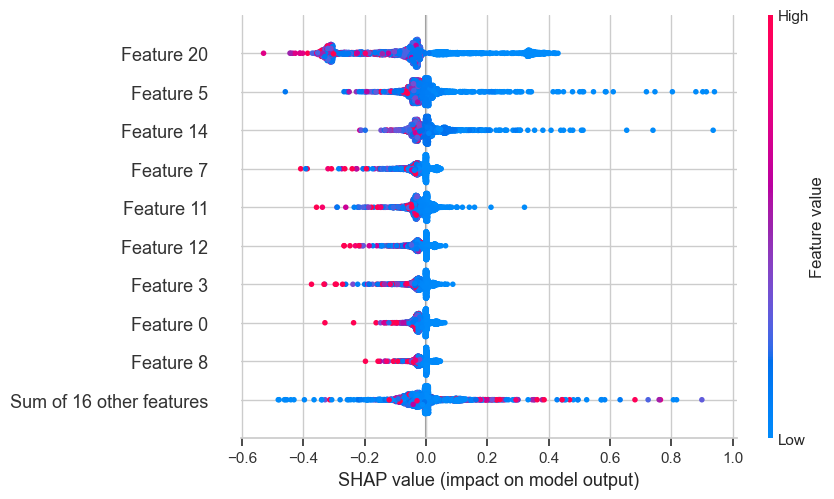

In [39]:
import shap
X_test_validation, Y_test_validation = X_test.loc[2018].to_numpy(dtype='int'), y_test.loc[2018].to_numpy(dtype='int')
Y_pred = best_model.predict(X_test_validation)

explainer = shap.KernelExplainer(best_model.predict,shap.sample(X_test_validation, 10) )
explanation = explainer(X_test_validation)

shap_values = explanation.values
shap.plots.beeswarm(explanation)


# SGD classifier

In [40]:
X_test = bankruptcy_merged_df_test[features]
y_test = bankruptcy_merged_df_test['status_label']
sm = SMOTE()
X_test_balanced, Y_test_balanced = sm.fit_resample(X=X_test.loc[2016:2018].to_numpy(dtype='int'),y=y_test.loc[2016:2018].to_numpy(dtype='int'))
steps_sgdc = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
              ('pca', PCA(n_components=0.95)),
              ('sgdc', SGDClassifier(penalty='elasticnet',alpha=8.8598e-05,max_iter=10000,l1_ratio=0.00781082))
             ]

pl_sgdc = Pipeline(steps_sgdc)
best_model = pl_sgdc.fit(X_test_balanced,Y_test_balanced)

  0%|          | 0/2723 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


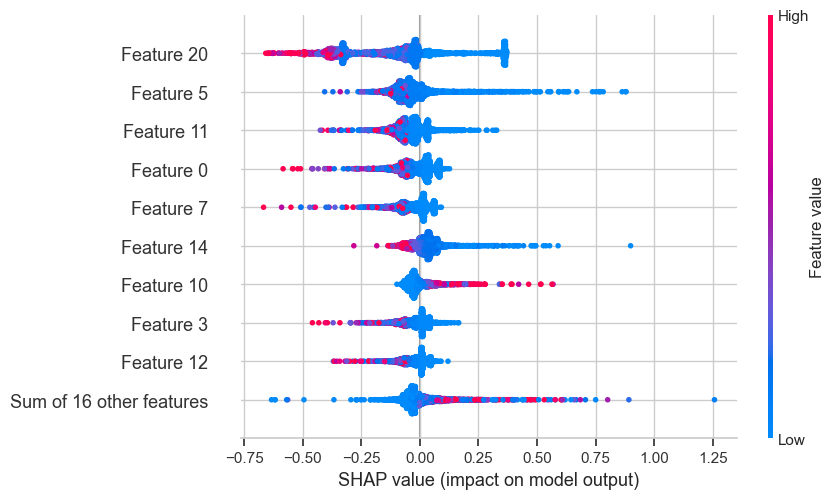

In [41]:
X_test_validation, Y_test_validation = X_test.loc[2018].to_numpy(dtype='int'), y_test.loc[2018].to_numpy(dtype='int')
Y_pred = best_model.predict(X_test_validation)
explainer = shap.KernelExplainer(best_model.predict,shap.sample(X_test_validation, 10) )
explanation = explainer(X_test_validation)

shap_values = explanation.values
shap.plots.beeswarm(explanation)


# XGboost classifier

In [301]:
X_test = bankruptcy_merged_df_test[features]
y_test = bankruptcy_merged_df_test['status_label']
sm = SMOTE()
X_test_balanced, Y_test_balanced = sm.fit_resample(X=X_test.loc[2016:2018].to_numpy(dtype='int'),y=y_test.loc[2016:2018].to_numpy(dtype='int'))
# Pipeline
steps_xgb = [
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('xgb', xgb.XGBClassifier(max_depth=3, learning_rate=0.01, n_estimators=100,subsample=1,colsample_bytree=1))
]

pl_xgb = Pipeline(steps_xgb)
best_model = pl_xgb.fit(X_test_balanced,Y_test_balanced)

  0%|          | 0/2723 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


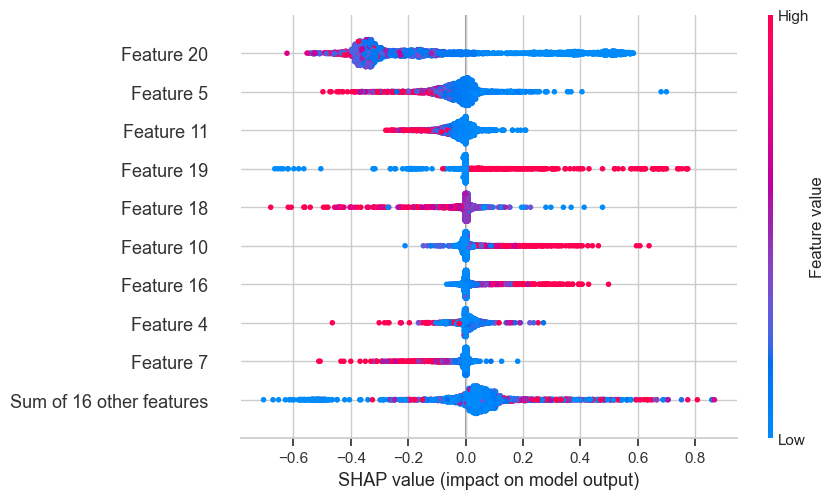

In [27]:
X_test_validation, Y_test_validation = X_test.loc[2018].to_numpy(dtype='int'), y_test.loc[2018].to_numpy(dtype='int')
Y_pred = best_model.predict(X_test_validation)
explainer = shap.KernelExplainer(best_model.predict,shap.sample(X_test_validation, 10) )
explanation = explainer(X_test_validation)

shap_values = explanation.values
shap.plots.beeswarm(explanation)

# shap_values_single = shap_kernel_explainer.shap_values(x_test.iloc[0,:])
# shap.force_plot(shap_kernel_explainer.expected_value[0],np.array(shap_values_single[0]), x_test.iloc[0,:],link='logit')


# Isolation Forest 

In [42]:
steps_iforest = [
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('iforest', IsolationForest(contamination='auto',bootstrap=False, random_state=42))
]

best_model = Pipeline(steps_iforest)

X_test = bankruptcy_merged_df_test[features]
y_test = bankruptcy_merged_df_test['status_label']
sm = SMOTE()
X_test_balanced, Y_test_balanced = sm.fit_resample(X=X_test.loc[2016:2018].to_numpy(dtype='int'),y=y_test.loc[2016:2018].to_numpy(dtype='int'))
# Fit the model
best_model.fit(X_test_balanced)



Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('iforest', IsolationForest(random_state=42))])

  0%|          | 0/2723 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


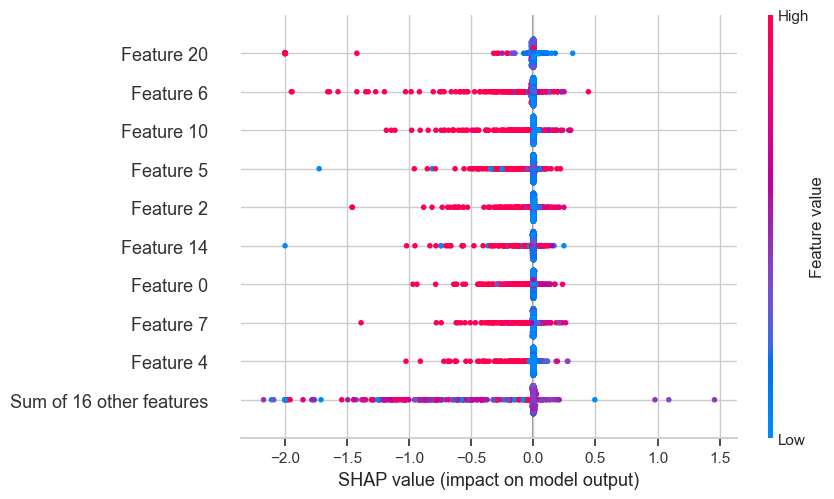

In [43]:
X_test_validation, Y_test_validation = X_test.loc[2018].to_numpy(dtype='int'), y_test.loc[2018].to_numpy(dtype='int')
Y_pred = best_model.predict(X_test_validation)
Y_pred = np.where(Y_pred == 1, 0, 1)
explainer = shap.KernelExplainer(best_model.predict,shap.sample(X_test_validation, 10) )
explanation = explainer(X_test_validation)

shap_values = explanation.values
shap.plots.beeswarm(explanation)

# Random Forest 

In [45]:
X_test = bankruptcy_merged_df_test[features]
y_test = bankruptcy_merged_df_test['status_label']
sm = SMOTE()
X_test_balanced, Y_test_balanced = sm.fit_resample(X=X_test.loc[2016:2018].to_numpy(dtype='int'),y=y_test.loc[2016:2018].to_numpy(dtype='int'))
# Pipeline
steps_rf = [
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('rf', RandomForestClassifier(max_depth=1,random_state=42))
]

pl_rf = Pipeline(steps_rf)
best_model = pl_rf.fit(X_test_balanced,Y_test_balanced)

  0%|          | 0/2723 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


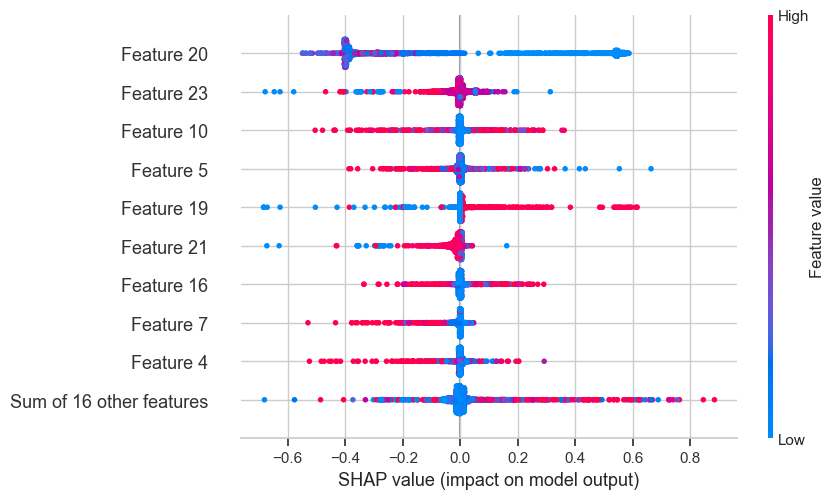

In [46]:
X_test_validation, Y_test_validation = X_test.loc[2018].to_numpy(dtype='int'), y_test.loc[2018].to_numpy(dtype='int')
Y_pred = best_model.predict(X_test_validation)
explainer = shap.KernelExplainer(best_model.predict,shap.sample(X_test_validation, 10) )
explanation = explainer(X_test_validation)

shap_values = explanation.values
shap.plots.beeswarm(explanation)